Student id: m.kirankumar.2@gmail.com<br/>
Date: May 23, 2022

**7. For this problem, use the population dataset, and perform the following:**<br/>
1.	EDA on the time series to find trends and seasonality.<br/>
2.	Forecast the population on the given dataset for the next 6 months. 


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

<p style="color:blue; ">Load popdata.csv into DataFrame<p/>

In [4]:
population = read_csv('popdata.csv')

<p style="color:blue; ">Population information of data<p/>

In [5]:
population.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 816 entries, 0 to 815
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   816 non-null    float64
 1   date    816 non-null    object 
dtypes: float64(1), object(1)
memory usage: 12.9+ KB


**date is of object/string type. Thus it requires to be type casted to pandas datatime**

In [6]:
population['date'] = pd.to_datetime(population['date'])
#also chaning default indexing to date
population = population.set_index('date')

In [7]:
population.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 816 entries, 1952-01-01 to 2019-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   816 non-null    float64
dtypes: float64(1)
memory usage: 12.8 KB


<p style="color:blue; ">Let's plot the Population value column graph<p/>

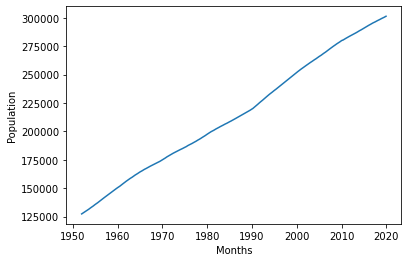

In [8]:
plt.plot(population)
plt.xlabel("Months")
plt.ylabel("Population")
plt.show()

<b>**Check No 1** <p style="color:red; ">Is Population data just a White Noise process?</p></b>

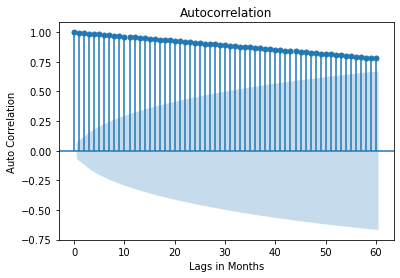

In [9]:
#checking for ACF for lag say about 60 (months)
sm.graphics.tsa.plot_acf(population, lags=60)
plt.xlabel('Lags in Months')
plt.ylabel("Auto Correlation")
plt.show()

For White Noise process, ACF falls abruptly falls to Zero for lag other than 0. However the ACF here is not aburptly falling rather gradual(asymptotical). Therefore Population data is not driven by White Noise(fairly) | Thus there exists be a possible predictability part of Data
<br/><br/>
**Inference** : Not a White Noise process | Further the data appears to be Non-Stationary in nature(visible)

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 10)'>

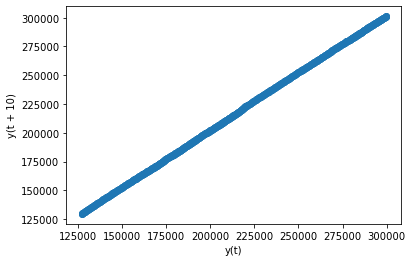

In [10]:
#Lag plot | for a wild guessed lag = 10 | for higher orders of lag the lag plot is non linear.
lag_plot(population, lag=10)

<b>**Check No 2** <p style="color:red; ">Is Population data Stationary?</p>

**Inference :** <p style="color:blue; "> At least, based on the above plots, average population (assuming that population is averaged for say 100 months as benchmark) Population is positively/linearly growing over years.<p/>
<br/>
Thus the Population data seems to be **Non-Stationary** . However it is better to check against a Statistical method

In [11]:
trend_output = seasonal_decompose(population, model='additive').trend
seasonal_output = seasonal_decompose(population, model='additive').seasonal
residual_output = seasonal_decompose(population, model='additive').resid

<p style="color:blue; ">Trend<p/>

<AxesSubplot:xlabel='date'>

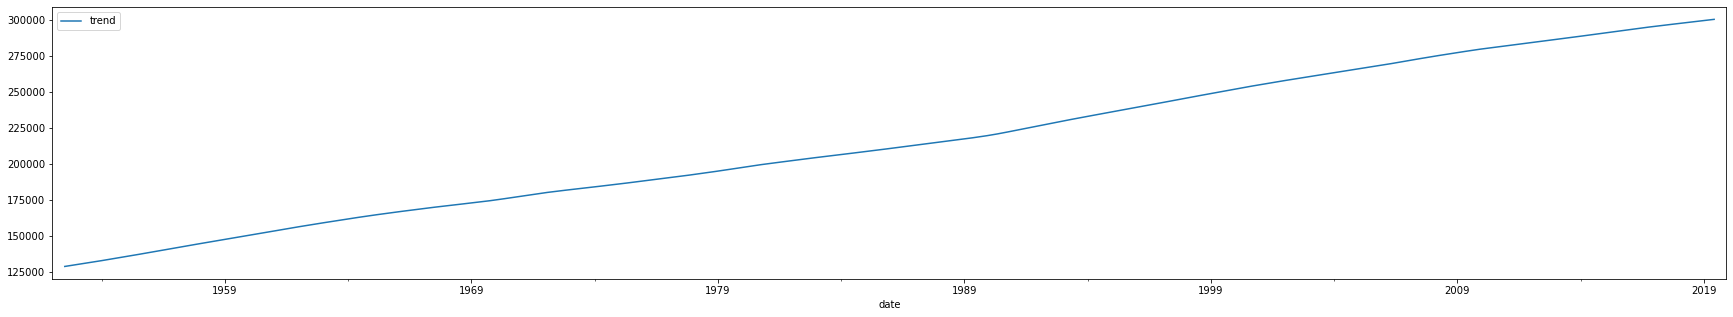

In [12]:
trend_output.plot(legend = True, figsize=(30, 5))

<p style="color:blue; ">Seasonality<p/>

<AxesSubplot:xlabel='date'>

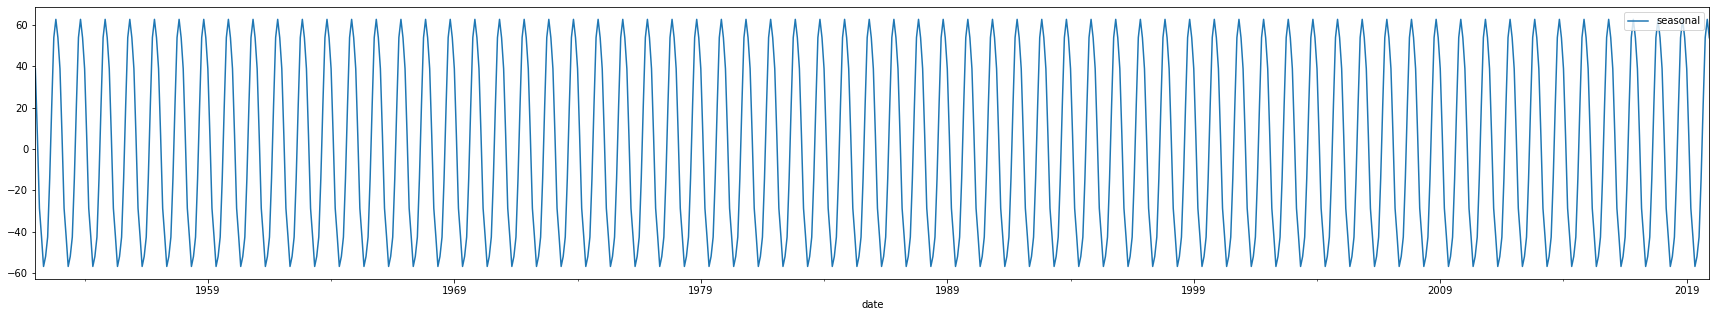

In [13]:
seasonal_output.plot(legend = True,figsize=(30, 5))

In [14]:
#residual_output.plot(legend = True,figsize=(30, 5))

Based on above Trend, Seasonal portions of data(using statsmodels) it is evident that the Trend is fairly linear and here is a seasonal componet as well<br/> 

This means that the data is Non-Stationary. Yet For confirmity of population data being Non-Stationary, lets perform Dicky-Fuller test(Augumented Dicky-Fuller) | This teting is done to make sure our hypothesis is wrong for confidence level of 0.05

In [84]:
from statsmodels.tsa.stattools import adfuller

In [86]:
result = adfuller(population, autolag='AIC') 
print(f"ADF test result is \t: {result}")

ADF test result is 	: (-0.6653174109472528, 0.8555297779110393, 17, 798, {'1%': -3.4385711275998583, '5%': -2.8651686574447375, '10%': -2.568702230639255}, 6593.486797606457)


In [46]:
print(f"p-value is {result[1]:.2f}")

p-value is 0.86


**The P-value is 0.86 which is > 0.05. Thus Null-hypothesis test cannot be rejected that the population data set is Stationary.**

<br/>

**Inference**: Population is Non-Stationary

In [47]:
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf

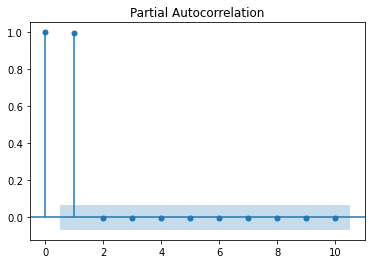

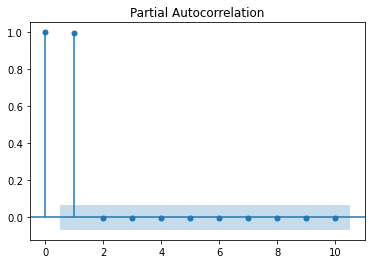

In [48]:
#Lets plot to Partial Auto correlation to visually estimate the best lag.
plot_pacf(population,lags=10)

because the Ppulation data is still Non-Stationary first converting the data to Stationary using pandas difference (diff) method, so that I can apply ARIMA model for forecasting

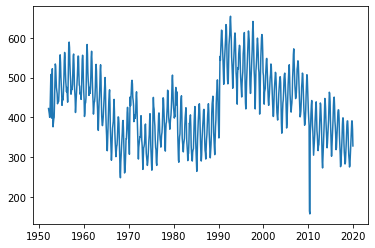

In [49]:
# Based on PACF, I decided to chose period 2 | Optimal value??!!
proc_population = population.diff(periods=2).dropna()
plt.plot(proc_population)
plt.show()

This data appears to be relatively stationary for period ranges. Let's choose period 1 (Let's once again perform ADF test to see whether data is stationary or now)

In [162]:
results = adfuller(proc_population)
print(f"The processed population data with period 1 appears to be stationary as per\n Augumented Dicky and Fuller Test as p-value {results[1]} is < 0.05")

The processed population data with period 1 appears to be stationary as per
 Augumented Dicky and Fuller Test as p-value 0.2822512276644459 is < 0.05


Now appying ARIMA model

https://www.statsmodels.org/stable/_modules/statsmodels/tsa/arima/model.html

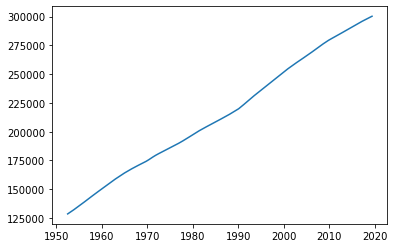

In [136]:
plt.plot(trend_output.dropna())
plt.show()

Note: Because I am little undecisive about the what Arima order to use i.e., p -> Lags in AR, d -> Degree of differencing, q -> MA order, I decided to use auto_arima module from pmdarima (I got help from internet)

In [38]:
!pip install pmdarima

In [41]:
from pmdarima import auto_arima

In [88]:
auto_arima(population, seasonal=True, trace=True, stationary=False)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=7351.451, Time=0.33 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=7389.026, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=7381.987, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=7383.820, Time=0.05 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=7311.381, Time=0.20 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=7365.358, Time=0.09 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=7377.876, Time=0.13 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=7366.475, Time=0.22 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=7351.871, Time=0.19 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=7373.282, Time=0.18 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=6849.154, Time=0.76 sec
 ARIMA(3,2,3)(0,0,0)[0]             : AIC=7344.418, Time=1.02 sec
 ARIMA(2,2,4)(0,0,0)[0]             : AIC=6850.862, Time=1.07 sec
 ARIMA(1,2,4)(0,0,0)[0]             : AIC=7247.280, Time=0.40 sec
 ARIMA(3,2,2)(0,0,0)[0]          

ARIMA(order=(2, 2, 3), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

#:My guess about p was correct but not others. Thus Arima(2, 2, 3) seems to be better 

In [50]:
from statsmodels.tsa.arima_model import ARIMA

In [56]:
import warnings
import warnings
warnings.filterwarnings('ignore')

Split Population data into Test and Train series

In [55]:
arima_result = ARIMA(population, order=(2,2,3))

In [78]:
#Splitting the Population into 80 : 20
INDEX_80PERC = int(0.8 * population.shape[0])
INDEX_80PERC

652

In [79]:
Train_Population = population.iloc[: INDEX_80PERC]
Test_Population = population.iloc[INDEX_80PERC:]

In [81]:
Train_Population.tail()

value
date                
2005-12-01  268421.0
2006-01-01  268637.0
2006-02-01  268844.0
2006-03-01  269050.0
2006-04-01  269271.0

In [82]:
Test_Population.head()

value
date                
2006-05-01  269486.0
2006-06-01  269729.0
2006-07-01  269986.0
2006-08-01  270253.0
2006-09-01  270544.0

In [97]:
model = ARIMA(Train_Population['value'], order=(2, 2, 3))

In [98]:
result1 = model.fit()

#Prediction time on Test data (population set)

In [154]:
Start= INDEX_80PERC
End = INDEX_80PERC+1+len(Test_Population)
pred=result1.predict(start=Start, end=End, dynamic=False, typ='levels')

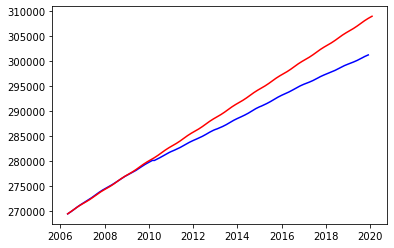

In [157]:
plt.plot(Test_Population['value'], 'b')
plt.plot(pred, 'r')
plt.show()

**Next 6 months forecasting of population**<br/>

Assuming that I was asked to estimate/forcaste population for upcoming 6 months i.e., Post 2019-12-01 from the population dataset
for <br/>
2020-01-01, <br/>
2020-02-01, <br/>
2020-03-01, <br/>
2020-04-01, <br/>
2020-05-01 and <br/>
2020-06-02 

In [191]:
# I chose Number 172 based on the doc_string information avaialble for forcast method. 
# Total Number of steps are 817.
# Train sample ends at 652 (80% of total population data)
# Test Data starts from 653 to 817 (indexs - though index has no impact on Time series)
# Because I was asked to predict next 6 month population,  I had to forcast 
#  from 653 to 817 + 6 (months) i.e, 825
# Thus steps => 825- 653 = 172

next_6_months_population  = result1.forecast(steps=172)

In [199]:
# Now picking the last six months from 817 onwards i.e, 
# 172-6 = 166
next_6_months_population[0][166:]

array([309249.72803683, 309471.42815848, 309708.72017549, 309962.3067399 ,
       310228.51279305, 310500.27486819])

In [201]:
#NEXT 6 MONTHS POUPLATION
pd.DataFrame({'value' : list( next_6_months_population[0][166:]), 
    'date' : ['01-01-2020','01-02-2020','01-03-2020','01-04-2020', '01-05-2020', '01-06-2020']
    })

value        date
0  309249.728037  01-01-2020
1  309471.428158  01-02-2020
2  309708.720175  01-03-2020
3  309962.306740  01-04-2020
4  310228.512793  01-05-2020
5  310500.274868  01-06-2020